# 10X scRNA-seq data Xenopus Laevis - Outlier identification

Novmeber, 20, 2020. We follow the analysis performed in the AVE paper for the identification of outlier cells in cluster 6.

Then we will perform a differential expression analysis between the outliers and the rest of cluster 6.

Last update: 14/12/2020

In [1]:
from pyod.models.knn import KNN
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter

In [2]:
%matplotlib inline

In [3]:
library(Seurat)
library(ggplot2)
library(cowplot)
library(SC3)

#Load the data
xenopus.combined <- readRDS(file = "xenopus_combined_and_clustered.rds")

Loading required package: scales

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


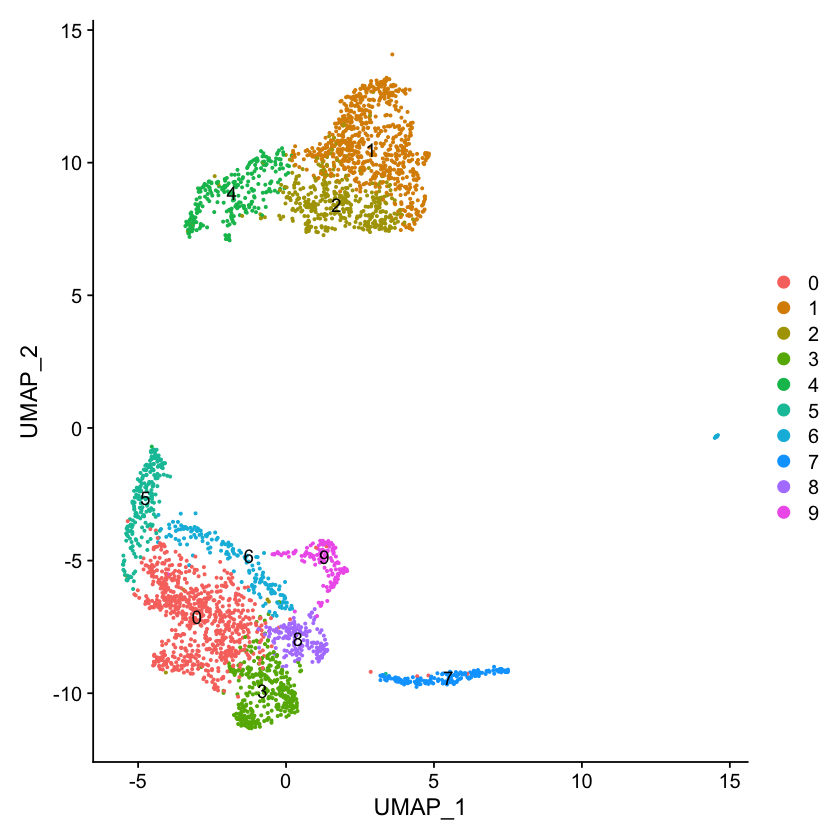

In [4]:
require(scales)

# Create vector of default ggplot2 colors
my_color_palette <- hue_pal()(11)[1:10]

DimPlot(xenopus.combined, reduction = "umap",cols=my_color_palette, label = TRUE)

# Automatic outlier identification

In [5]:
# Save the expression matrix for cluster 6 cells
xenopus.combined.cluster6 <- subset(xenopus.combined, idents=6)

HVGs <- rownames(xenopus.combined.cluster6)

DefaultAssay(xenopus.combined.cluster6) <- "integrated"

expmat.cluster6 <- as.data.frame(GetAssayData(object = xenopus.combined.cluster6))
metadata.cluster6 <- xenopus.combined.cluster6[[]]
umap.coords.cluster6 <- as.data.frame(Embeddings(xenopus.combined.cluster6,reduction='umap'))
umap.coords <- as.data.frame(Embeddings(xenopus.combined,reduction='umap'))
#xenopus.combined.cluster6.umap <- Embeddings(object = xenopus.combined.cluster6[["umap"]])

In [6]:
%get expmat.cluster6 --from R
%get metadata.cluster6 --from R
%get HVGs --from R
%get umap.coords.cluster6 --from R
%get umap.coords --from R
#%get xenopus.combined.cluster6.umap --from R

Variable expmat.cluster6 is put to SoS as expmat_cluster6
Loading required package: feather

Variable metadata.cluster6 is put to SoS as metadata_cluster6
Variable umap.coords.cluster6 is put to SoS as umap_coords_cluster6
Variable umap.coords is put to SoS as umap_coords


Counter({0: 163, 1: 14})


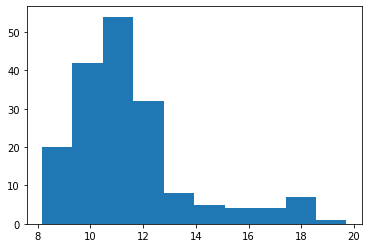

In [7]:
clf_name = 'KNN'
clf = KNN(n_neighbors=15,contamination=0.075)
clf.fit(expmat_cluster6.T)
plt.hist(clf.decision_scores_)
clf.threshold_
print(Counter(list(clf.labels_)))
out_labels=list(clf.labels_)

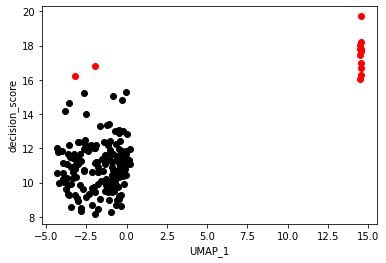

In [8]:
metadata_cluster6['umap1']=list(umap_coords_cluster6['UMAP_1'])
metadata_cluster6['scores']=clf.decision_scores_
metadata_cluster6['outliers']=out_labels

plt.figure()
plt.xlabel('UMAP_1')
plt.ylabel('decision_score')
for i in range(len(metadata_cluster6)):
    if metadata_cluster6['outliers'].iloc[i]==1:
        plt.scatter(metadata_cluster6['umap1'].iloc[i],metadata_cluster6['scores'].iloc[i],color='red')
    else:
        plt.scatter(metadata_cluster6['umap1'].iloc[i],metadata_cluster6['scores'].iloc[i],color='black')

14 outlier cells have been identified in cluster 6: 12 are those very far in the UMAP, 2 cells instead lie with the rest of cluster 6 in the UMAP.

## Exploration of the charcteristics of the outlier cells

We will check the correspondance between the distances from the cluster centroids in the low-dimensional (first 2 UMAP coordinates), high-dimensional (2000 genes used for UMAP computation and clustering) and the decision score used in the outlier detection algorithm.

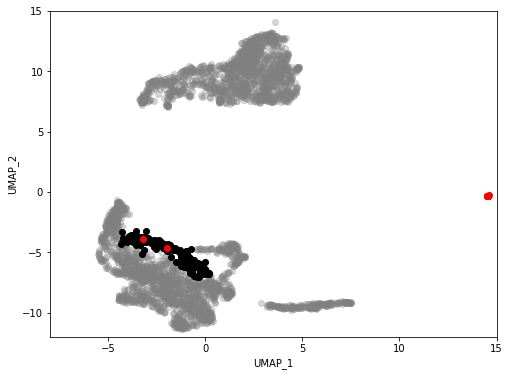

In [9]:
metadata_cluster6['umap2']=list(umap_coords_cluster6['UMAP_2'])

plt.figure(figsize=(8,6))
plt.xlim(-8,15)
plt.ylim(-12,15)
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.scatter(umap_coords['UMAP_1'],umap_coords['UMAP_2'],color='grey',alpha=0.3)
for i in range(len(metadata_cluster6)):
    if metadata_cluster6['outliers'].iloc[i]!=1:
        plt.scatter(metadata_cluster6['umap1'].iloc[i],metadata_cluster6['umap2'].iloc[i],color='black')
#     else:
#         plt.scatter(metadata_cluster6['umap1'].iloc[i],metadata_cluster6['umap2'].iloc[i],color='black',
#                    alpha=0.3)
        
for i in range(len(metadata_cluster6)):
    if metadata_cluster6['outliers'].iloc[i]==1:
        plt.scatter(metadata_cluster6['umap1'].iloc[i],metadata_cluster6['umap2'].iloc[i],color='red')

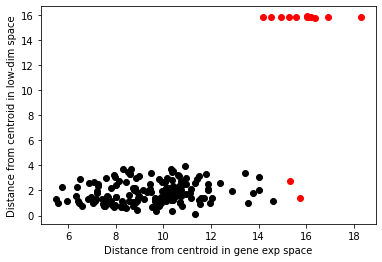

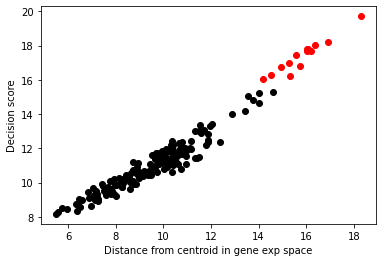

(None, None)

In [10]:
import pandas as pd
import numpy as np

# umap_coords=pd.DataFrame(data={'umap1':xenopus_combined_cluster6_umap[:,0],
#                               'umap2':xenopus_combined_cluster6_umap[:,1]},
#                          index=expmat_cluster6.columns)
# umap_coords=umap_coords.T
umap_coords_cluster6=umap_coords_cluster6.T
centroid_high_dim=expmat_cluster6.mean(axis=1)
centroid_low_dim=umap_coords_cluster6.mean(axis=1)
Euc_dist_high_dim=pd.DataFrame(index=expmat_cluster6.columns, 
                      data={'dist': [0.0]*len(expmat_cluster6.columns)})
Euc_dist_low_dim=pd.DataFrame(index=expmat_cluster6.columns, 
                      data={'dist': [0.0]*len(expmat_cluster6.columns)})

for i in range(len(expmat_cluster6.columns)):
    Euc_dist_high_dim.iloc[i]=np.linalg.norm(expmat_cluster6.iloc[:,i]-centroid_high_dim)
    Euc_dist_low_dim.iloc[i]=np.linalg.norm(umap_coords_cluster6.iloc[:,i]-centroid_low_dim)
    
plt.figure()
plt.xlabel('Distance from centroid in gene exp space')
plt.ylabel('Distance from centroid in low-dim space')
for i in range(len(metadata_cluster6)):
    if metadata_cluster6['outliers'].iloc[i]==1:
        plt.scatter(Euc_dist_high_dim.iloc[i],Euc_dist_low_dim.iloc[i],color='red')
    else:
        plt.scatter(Euc_dist_high_dim.iloc[i],Euc_dist_low_dim.iloc[i],color='black')
plt.show(),plt.close()

plt.figure()
plt.xlabel('Distance from centroid in gene exp space')
plt.ylabel('Decision score')
for i in range(len(metadata_cluster6)):
    if metadata_cluster6['outliers'].iloc[i]==1:
        plt.scatter(Euc_dist_high_dim.iloc[i],metadata_cluster6['scores'].iloc[i],color='red')
    else:
        plt.scatter(Euc_dist_high_dim.iloc[i],metadata_cluster6['scores'].iloc[i],color='black')
plt.show(),plt.close()

The 12 cells are sharply separated from the other 2 in UMAP space, but this sharp separation is not observed in gene-expression space.

The second plot clarifies why the 2 cells have been selected as outliers.

# Different k and model combination (NOT USED)

In [14]:
# from pyod.utils.utility import standardizer
# from pyod.models.combination import aom, moa, average, maximization

In [18]:
# k_list = [5,10,15,20,25,30]
# n_clf=len(k_list)

# scores = np.zeros([expmat_cluster6.shape[1], n_clf])

# for i in range(n_clf):
#     k = k_list[i]

#     clf = KNN(n_neighbors=k, contamination=0.075)
#     clf.fit(expmat_cluster6.T)
    
#     scores[:, i] = clf.decision_scores_

    
# # scores have to be normalized before combination
# test_scores_norm = standardizer(scores)

# comb_by_average = average(test_scores_norm)
# comb_by_maximization = maximization(test_scores_norm)
# comb_by_aom = aom(test_scores_norm, 3) # 5 groups
# comb_by_moa = moa(test_scores_norm, 3) # 5 groups
# # clf = KNN(n_neighbors=15,contamination=0.075)
# # plt.hist(clf.decision_scores_)
# # clf.threshold_
# # print(Counter(list(clf.labels_)))
# # out_labels=list(clf.labels_)

In [ ]:
# plt.figure()
# plt.axhline(1.75,linestyle='dashed',linewidth=3)
# plt.xlabel('Distance from centroid in low-dim space')
# plt.ylabel('Decision scores combined by average')
# for i in range(len(metadata_cluster6)):
#     if metadata_cluster6['outliers'].iloc[i]==1:
#         plt.scatter(Euc_dist_low_dim.iloc[i],comb_by_average[i],color='red')
#     else:
#         plt.scatter(Euc_dist_low_dim.iloc[i],comb_by_average[i],color='black')
# plt.show(),plt.close()

# plt.figure()
# plt.axhline(2,linestyle='dashed',linewidth=3)
# plt.xlabel('Distance from centroid in low-dim space')
# plt.ylabel('Decision scores combined by maximization')
# for i in range(len(metadata_cluster6)):
#     if metadata_cluster6['outliers'].iloc[i]==1:
#         plt.scatter(Euc_dist_low_dim.iloc[i],comb_by_maximization[i],color='red')
#     else:
#         plt.scatter(Euc_dist_low_dim.iloc[i],comb_by_maximization[i],color='black')
# plt.show(),plt.close()

# plt.figure()
# plt.axhline(2,linestyle='dashed',linewidth=3)
# plt.xlabel('Distance from centroid in low-dim space')
# plt.ylabel('Decision scores combined by aom')
# for i in range(len(metadata_cluster6)):
#     if metadata_cluster6['outliers'].iloc[i]==1:
#         plt.scatter(Euc_dist_low_dim.iloc[i],comb_by_aom[i],color='red')
#     else:
#         plt.scatter(Euc_dist_low_dim.iloc[i],comb_by_aom[i],color='black')
# plt.show(),plt.close()

# plt.figure()
# plt.axhline(2,linestyle='dashed',linewidth=3)
# plt.xlabel('Distance from centroid in low-dim space')
# plt.ylabel('Decision scores combined by moa')
# for i in range(len(metadata_cluster6)):
#     if metadata_cluster6['outliers'].iloc[i]==1:
#         plt.scatter(Euc_dist_low_dim.iloc[i],comb_by_moa[i],color='red')
#     else:
#         plt.scatter(Euc_dist_low_dim.iloc[i],comb_by_moa[i],color='black')
# plt.show(),plt.close()

In [ ]:
# plt.figure()
# plt.xlabel('Distance from centroid in gene exp space')
# plt.ylabel('Decision scores combined by average')
# for i in range(len(metadata_cluster6)):
#     if metadata_cluster6['outliers'].iloc[i]==1:
#         plt.scatter(Euc_dist_high_dim.iloc[i],comb_by_average[i],color='red')
#     else:
#         plt.scatter(Euc_dist_high_dim.iloc[i],comb_by_average[i],color='black')
# plt.show(),plt.close()

# plt.figure()
# plt.xlabel('Distance from centroid in gene exp space')
# plt.ylabel('Decision scores combined by maximization')
# for i in range(len(metadata_cluster6)):
#     if metadata_cluster6['outliers'].iloc[i]==1:
#         plt.scatter(Euc_dist_high_dim.iloc[i],comb_by_maximization[i],color='red')
#     else:
#         plt.scatter(Euc_dist_high_dim.iloc[i],comb_by_maximization[i],color='black')
# plt.show(),plt.close()

# plt.figure()
# plt.xlabel('Distance from centroid in gene exp space')
# plt.ylabel('Decision scores combined by aom')
# for i in range(len(metadata_cluster6)):
#     if metadata_cluster6['outliers'].iloc[i]==1:
#         plt.scatter(Euc_dist_high_dim.iloc[i],comb_by_aom[i],color='red')
#     else:
#         plt.scatter(Euc_dist_high_dim.iloc[i],comb_by_aom[i],color='black')
# plt.show(),plt.close()

# plt.figure()
# plt.xlabel('Distance from centroid in gene exp space')
# plt.ylabel('Decision scores combined by moa')
# for i in range(len(metadata_cluster6)):
#     if metadata_cluster6['outliers'].iloc[i]==1:
#         plt.scatter(Euc_dist_high_dim.iloc[i],comb_by_moa[i],color='red')
#     else:
#         plt.scatter(Euc_dist_high_dim.iloc[i],comb_by_moa[i],color='black')
# plt.show(),plt.close()

## Further checks on the outlier cells

In [11]:
outliers=list(metadata_cluster6['outliers'])
out_cell_names=list(metadata_cluster6[metadata_cluster6['outliers']==1].index)

In [22]:
len(out_cell_names)

14

Scibet assignment using X. Tropicalis atlas

In [13]:
%get outliers
%get out_cell_names

# Subset Seurat object for those cells and check the IVF/NT, cluster and batch composition
xenopus.combined.outliers <- subset(xenopus.combined, cells=out_cell_names)
tropical.map.out <- read.table("cl6_outl_pred.csv",sep=',',row.names=1,header=TRUE)
colnames(xenopus.combined.outliers)==rownames(tropical.map.out)
umap <- as.data.frame(Embeddings(xenopus.combined.outliers,reduction='umap'))
umap$pred <- tropical.map.out$prediction_scibet
umap

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

,UMAP_1,UMAP_2,pred
,<dbl>,<dbl>,<fct>
ACTTCGCGTCGTATGT.1,-2.000740,-4.6700590,S12-non-neural ectoderm
AGGGTTTGTACTAGCT.1,14.597543,-0.2707425,S12-involuted ventral mesoderm
CCACAAAGTGAGTGAC.1,14.559537,-0.3085818,S12-neural plate
GGAGATGTCGAATCCA.1,14.523696,-0.3446826,S12-neural plate
TACAACGTCGCATTAG.1,14.492379,-0.3760393,S12-neural plate
TTACGCCGTACCTAGT.1,14.530295,-0.3380834,S12-involuted ventral mesoderm
AATCGACTCTCATGGA.1,14.544744,-0.3236036,S12-involuted ventral mesoderm
CCTTCAGTCGGTCGAC.1,14.548122,-0.3202340,S12-Spemann organizer (endoderm)
GACTCAATCTATACGG.1,14.547782,-0.3205845,S12-involuted ventral mesoderm


We do not learn much from Scibet assignment, but some cells with high UMAP1 are assigned to mesoderm and endoderm cell types, meaning that they could be a contamination.

This is supported by the composition of the outlier cells' group: there are both IVF and NT cells and they come from 3 (over 4) batches.

In [14]:
# Check to which cluster the outliers belong
table(Idents(xenopus.combined.outliers))

# Check composition in terms of batch
table(Idents(xenopus.combined.outliers), xenopus.combined.outliers$stim)

# Check composition in terms of condition
table(Idents(xenopus.combined.outliers), xenopus.combined.outliers$isnt)


 6 
14 

   
    SIGAB2 SIGAH12 SIGAH5
  6      2       6      6

   
    IVF NT
  6   6  8

Check quality metrics in outlier cells and rest of cluster 6

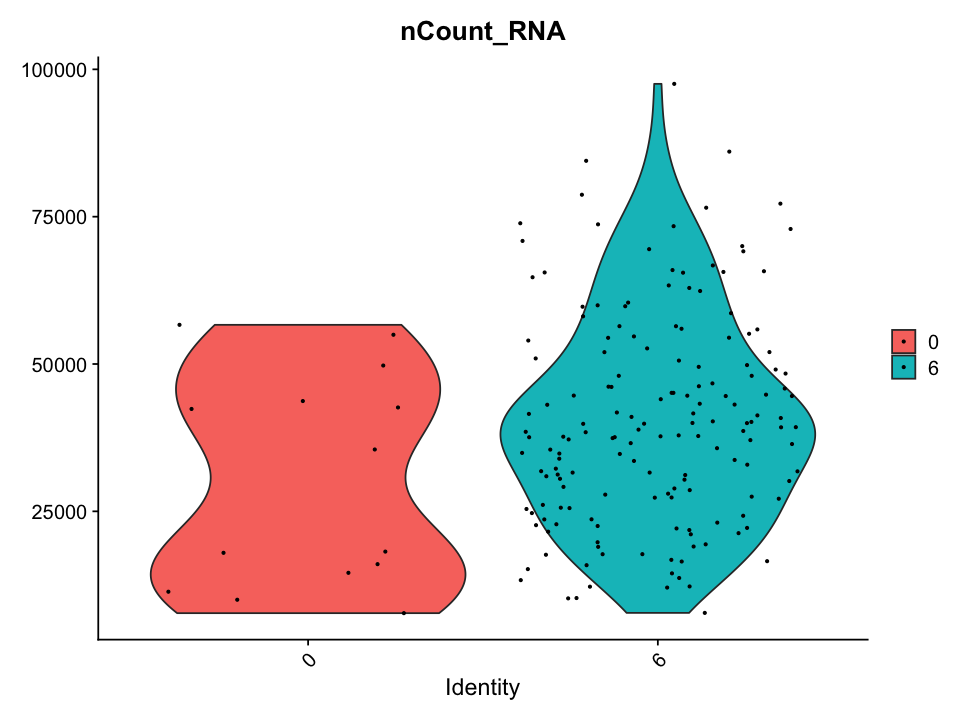

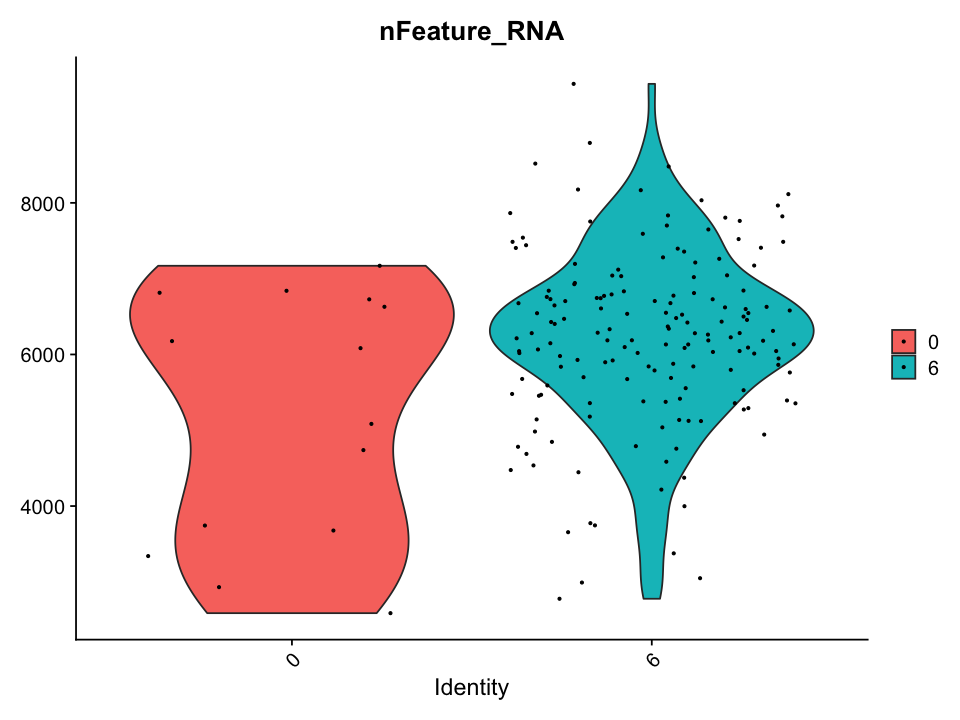

In [15]:
library(repr)
options(repr.plot.width=8, repr.plot.height=6)


xenopus.combined.cluster6[['seurat_clusters_new']] <- xenopus.combined.cluster6[['seurat_clusters']]
xenopus.combined.cluster6[['seurat_clusters_new']][out_cell_names,] <- 0

out.labels <- xenopus.combined.cluster6[['seurat_clusters_new']]

p3<- VlnPlot(xenopus.combined.cluster6, group.by='seurat_clusters_new', features = 'nCount_RNA',pt.size = 0.5)
#p4<- VlnPlot(xenopus.combined, features = 'nCount_RNA',split.by = "isnt",pt.size = 0.5)
p3

p4<- VlnPlot(xenopus.combined.cluster6, group.by='seurat_clusters_new', features = 'nFeature_RNA',pt.size = 0.5)
#p4<- VlnPlot(xenopus.combined, features = 'nFeature_RNA',split.by = "isnt",pt.size = 0.5)
p4

In [16]:
xenopus.combined.cluster6[['seurat_clusters_new_2']] <- xenopus.combined.cluster6[['seurat_clusters_new']]
xenopus.combined.cluster6[['seurat_clusters_new_2']][c('ACTTCGCGTCGTATGT.1','GTGCACGAGCACGTCC.1'),] <- 1

Outlier cells express endodermal and mesodermal genes (these were found through the differential expression analysis below).

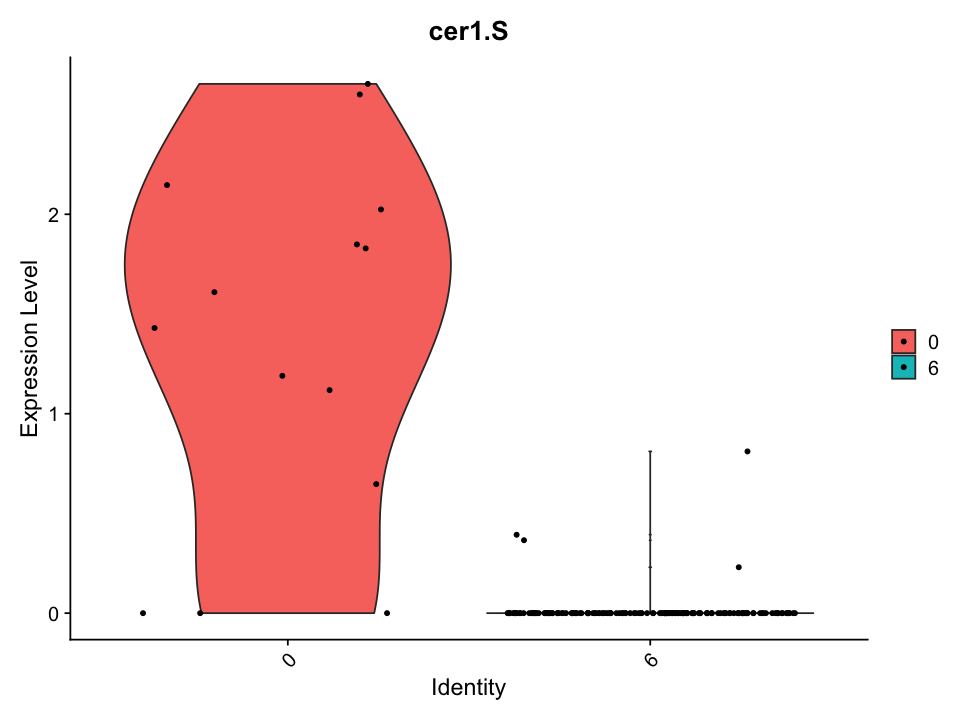

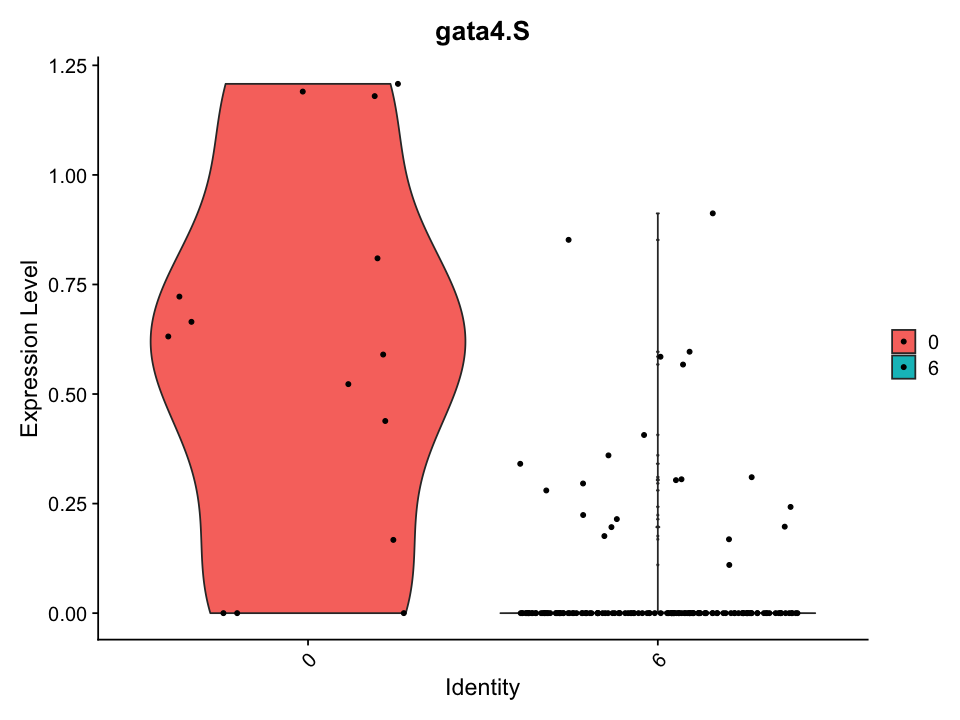

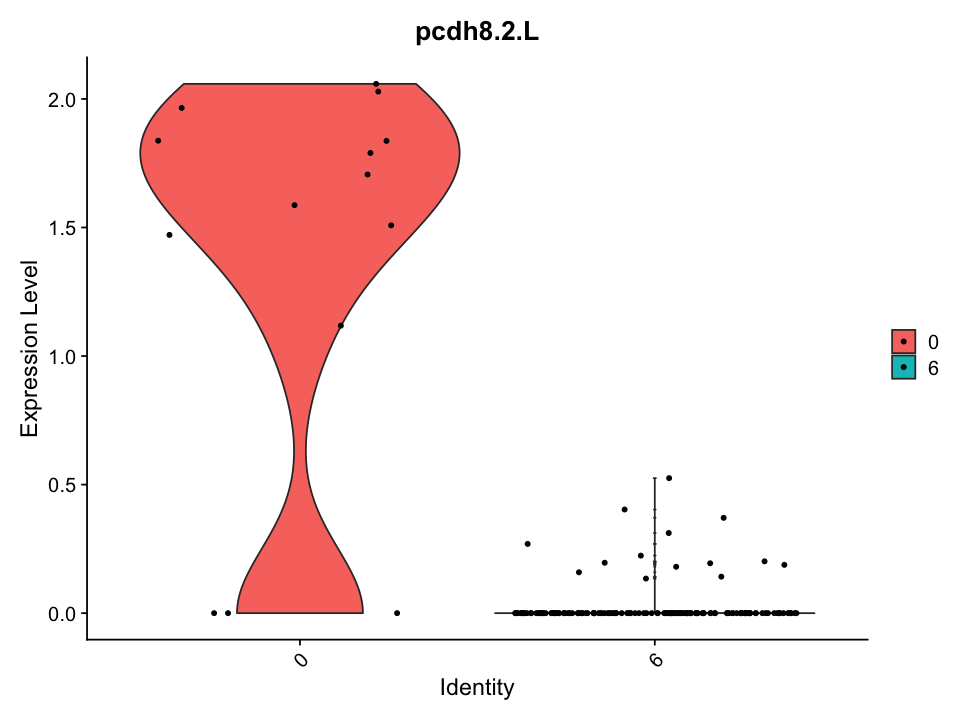

In [17]:
p3<- VlnPlot(xenopus.combined.cluster6, group.by='seurat_clusters_new',
             features = 'cer1.S',pt.size = 1,assay='RNA')
#p4<- VlnPlot(xenopus.combined, features = 'nCount_RNA',split.by = "isnt",pt.size = 0.5)
p3

p4<- VlnPlot(xenopus.combined.cluster6, group.by='seurat_clusters_new',
             features = 'gata4.S',pt.size = 1,assay='RNA')
#p4<- VlnPlot(xenopus.combined, features = 'nCount_RNA',split.by = "isnt",pt.size = 0.5)
p4

p5<- VlnPlot(xenopus.combined.cluster6, group.by='seurat_clusters_new',
             features = 'pcdh8.2.L',pt.size = 1,assay='RNA')
#p4<- VlnPlot(xenopus.combined, features = 'nCount_RNA',split.by = "isnt",pt.size = 0.5)
p5

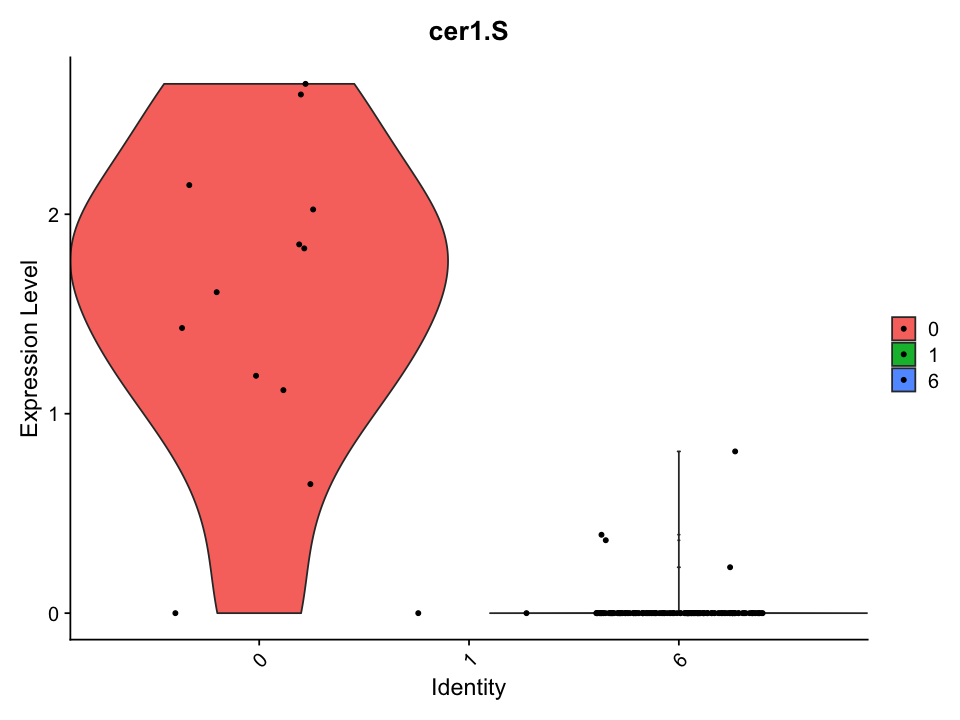

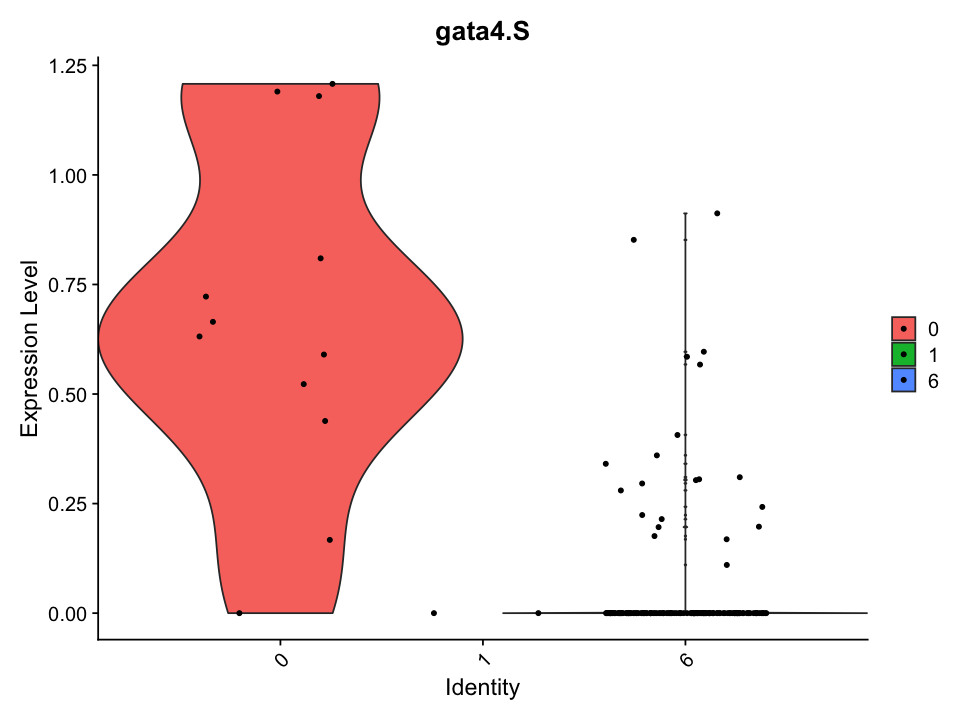

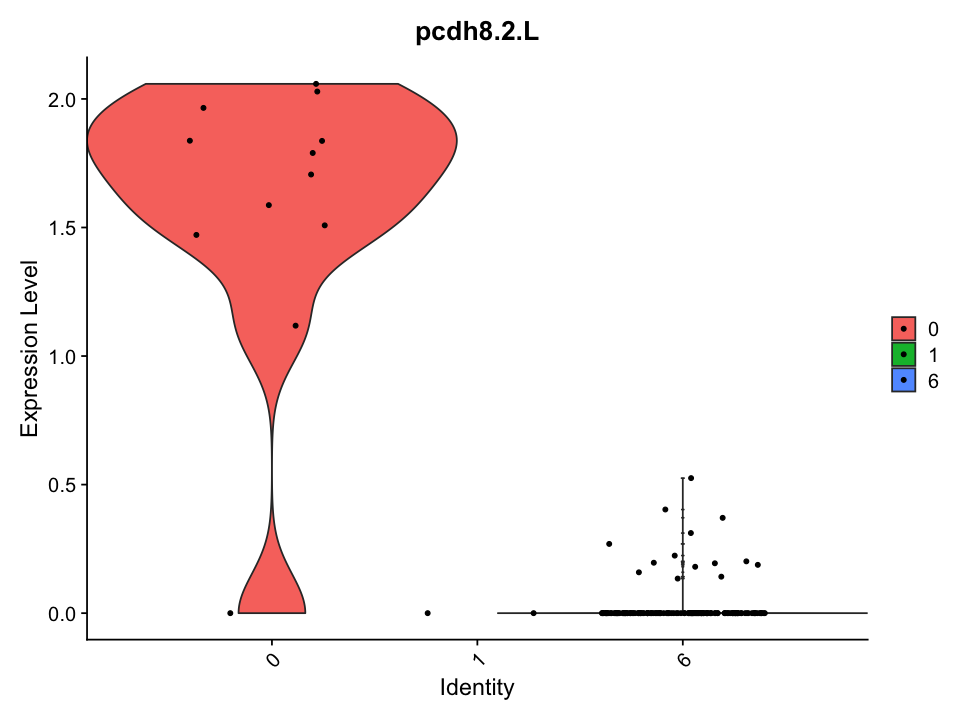

In [46]:
p3<- VlnPlot(xenopus.combined.cluster6, group.by='seurat_clusters_new_2',
             features = 'cer1.S',pt.size = 1,assay='RNA')
#p4<- VlnPlot(xenopus.combined, features = 'nCount_RNA',split.by = "isnt",pt.size = 0.5)
p3

p4<- VlnPlot(xenopus.combined.cluster6, group.by='seurat_clusters_new_2',
             features = 'gata4.S',pt.size = 1,assay='RNA')
#p4<- VlnPlot(xenopus.combined, features = 'nCount_RNA',split.by = "isnt",pt.size = 0.5)
p4

p5<- VlnPlot(xenopus.combined.cluster6, group.by='seurat_clusters_new_2',
             features = 'pcdh8.2.L',pt.size = 1,assay='RNA')
#p4<- VlnPlot(xenopus.combined, features = 'nCount_RNA',split.by = "isnt",pt.size = 0.5)
p5

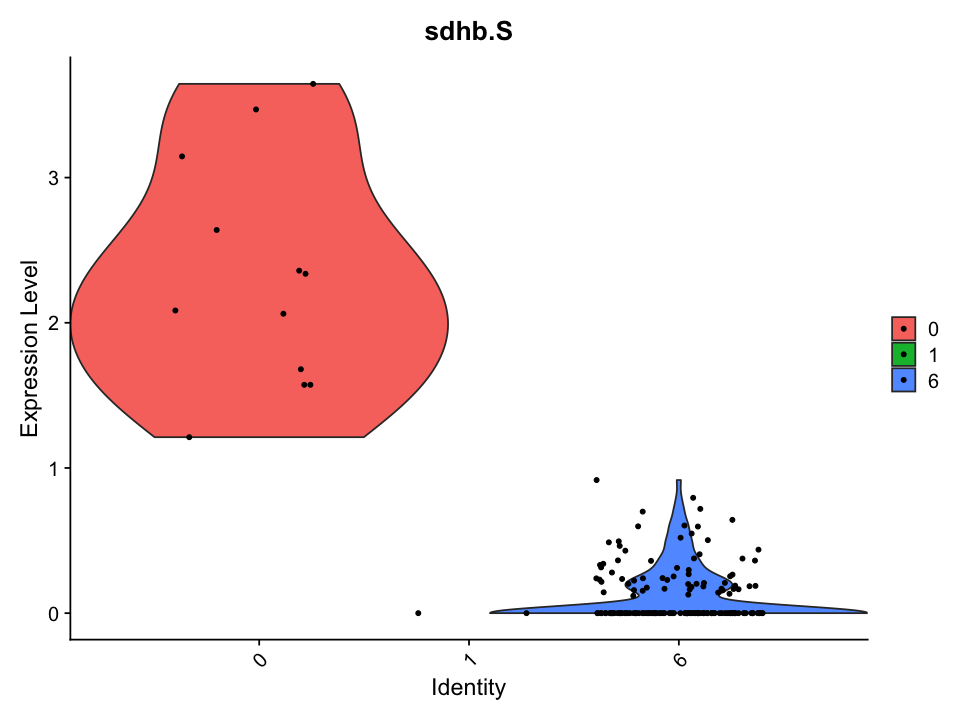

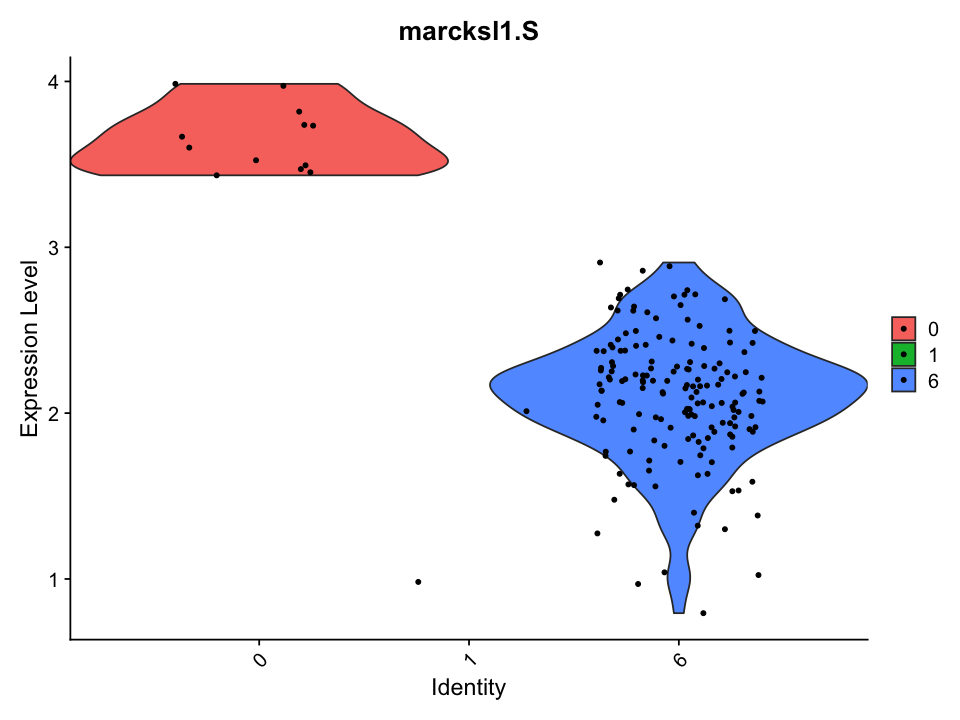

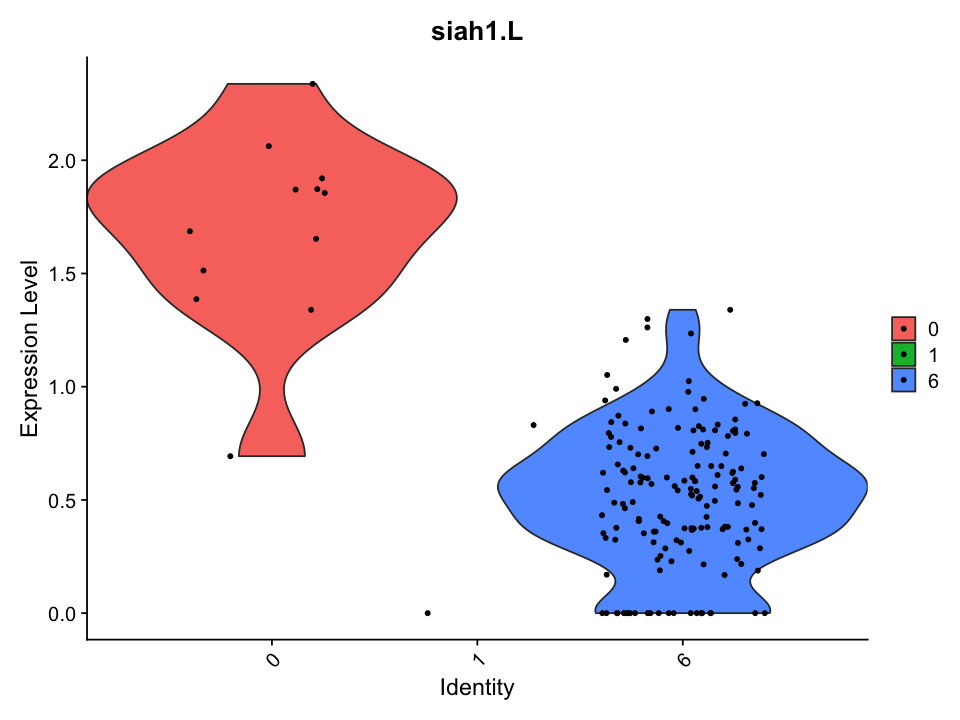

In [47]:
p3<- VlnPlot(xenopus.combined.cluster6, group.by='seurat_clusters_new_2',
             features = 'sdhb.S',pt.size = 1,assay='RNA')
#p4<- VlnPlot(xenopus.combined, features = 'nCount_RNA',split.by = "isnt",pt.size = 0.5)
p3

p4<- VlnPlot(xenopus.combined.cluster6, group.by='seurat_clusters_new_2',
             features = 'marcksl1.S',pt.size = 1,assay='RNA')
#p4<- VlnPlot(xenopus.combined, features = 'nCount_RNA',split.by = "isnt",pt.size = 0.5)
p4

p5<- VlnPlot(xenopus.combined.cluster6, group.by='seurat_clusters_new_2',
             features = 'siah1.L',pt.size = 1,assay='RNA')
#p4<- VlnPlot(xenopus.combined, features = 'nCount_RNA',split.by = "isnt",pt.size = 0.5)
p5

In [34]:
as.matrix(GetAssayData(xenopus.combined.cluster6[c('cer1.S','gata4.S','pcdh8.2.L'),
                                       WhichCells(xenopus.combined.cluster6,
                                       cells=c('ACTTCGCGTCGTATGT.1','GTGCACGAGCACGTCC.1'))],
            assay = "RNA", slot = "data"))

,ACTTCGCGTCGTATGT.1,GTGCACGAGCACGTCC.1
cer1.S,0,0
pcdh8.2.L,0,0
gata4.S,0,0


In [36]:
t(as.matrix(GetAssayData(xenopus.combined.cluster6[c('cer1.S','gata4.S','pcdh8.2.L'),
                                       WhichCells(xenopus.combined.cluster6,
                                       cells=c('ACTTCGCGTCGTATGT.1','GTGCACGAGCACGTCC.1'))],
            assay = "RNA", slot = "data")))

,cer1.S,pcdh8.2.L,gata4.S
ACTTCGCGTCGTATGT.1,0,0,0
GTGCACGAGCACGTCC.1,0,0,0


In [44]:
t(as.matrix(GetAssayData(xenopus.combined.cluster6[c('sdhb.S','marcksl1.S','siah1.L','slc25a1.L','ugdh.L',
'slc6a14.2.L','rdh10.L','krt18.S','marcksl1.L','ahnak-like.S'),
                                       WhichCells(xenopus.combined.cluster6,
                                       cells=c('ACTTCGCGTCGTATGT.1','GTGCACGAGCACGTCC.1'))],
            assay = "RNA", slot = "data")))

,rdh10.L,ugdh.L,slc25a1.L,marcksl1.L,marcksl1.S,krt18.S,siah1.L,ahnak-like.S,sdhb.S,slc6a14.2.L
ACTTCGCGTCGTATGT.1,0,0.8306603,0.8306603,1.5860671,2.0114528,0.0000000,0.8306603,0,0,0.0000000
GTGCACGAGCACGTCC.1,0,0.7482979,0.0000000,0.4425681,0.9821158,0.4425681,0.0000000,0,0,0.4425681


# Differential expression outliers/rest of cluster 6

In [14]:
# Load the raw data
xenopus.combined.raw=readRDS(file = "xenopus_combined_and_clustered_raw.rds")

# Select only cluster 6 cells
xenopus.combined.cluster6.raw <- subset(xenopus.combined.raw, idents=6)

# Re-label the outliers
Idents(object = xenopus.combined.cluster6.raw, cells = out_cell_names) <- 0

# Convert to sce object
xenopus.combined.cluster6.raw.sce <- as.SingleCellExperiment(xenopus.combined.cluster6.raw)

In [15]:
library("DESeq2")
library("scran")
library("BiocParallel")
register(MulticoreParam(4))

DE_clusters <-function(sce,i1,i2){
    
    dds <- convertTo(sce, type="DESeq2")
    dds$exp <- sce$exp
    dds$ident <- sce$ident
    keep <- rowSums(counts(dds)) >= 10
    dds <- dds[keep,]
    print(dds)
    dds <- DESeqDataSet(dds, design = ~ exp + ident)                     
    dds <- DESeq(dds,parallel=TRUE)
    res <- results(dds, contrast=c("ident",i1,i2),parallel=TRUE)
    res <- res[order(res$padj, decreasing = F),]
    #res <- res[order(res$log2FoldChange, decreasing = T),]
    res <- res[!is.na(res$padj),]
#     res <- res[res$padj< 0.05,]
#     res <- res[abs(res$log2FoldChange) > 1.0,]
    res <- as.data.frame.matrix(res)
    res
    }

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, evalq, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, rank, rbind,
    rowMeans, rowSums, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max

In [16]:
res <- DE_clusters(xenopus.combined.cluster6.raw.sce,"0","6")

converting counts to integer mode



class: DESeqDataSet 
dim: 13887 177 
metadata(1): version
assays(1): counts
rownames(13887): Xelaev18000010m.g tmem200c.S ... LOC101731436.S
  loc398467.S
rowData names(0):
colnames(177): AAACCCAGTCTGCAAT.1 AACCCAACAATGTCTG.1 ...
  TGTTCATCAGATCACT.1 TGTTCTACATGCCGCA.1
colData names(2): exp ident


Warning message in DESeqDataSet(dds, design = ~exp + ident):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers

-- replacing outliers and refitting for 11 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [17]:
# PreFilter <-function(sce){
#     dds <- convertTo(sce, type="DESeq2")
#     keep <- rowSums(counts(dds)) >= 10
#     dds <- dds[keep,]
#     rownames(dds)
#     }

# # Return the background list for GO analysis
# bg <- PreFilter(xenopus.combined.cluster6.raw.sce)

In [18]:
res.up.outliers <- res[res$padj< 0.05,]
res.up.outliers <- res.up.outliers[res.up.outliers$log2FoldChange > 0,]
res.down.outliers <- res[res$padj< 0.05,]
res.down.outliers <- res.down.outliers[res.down.outliers$log2FoldChange < 0,]

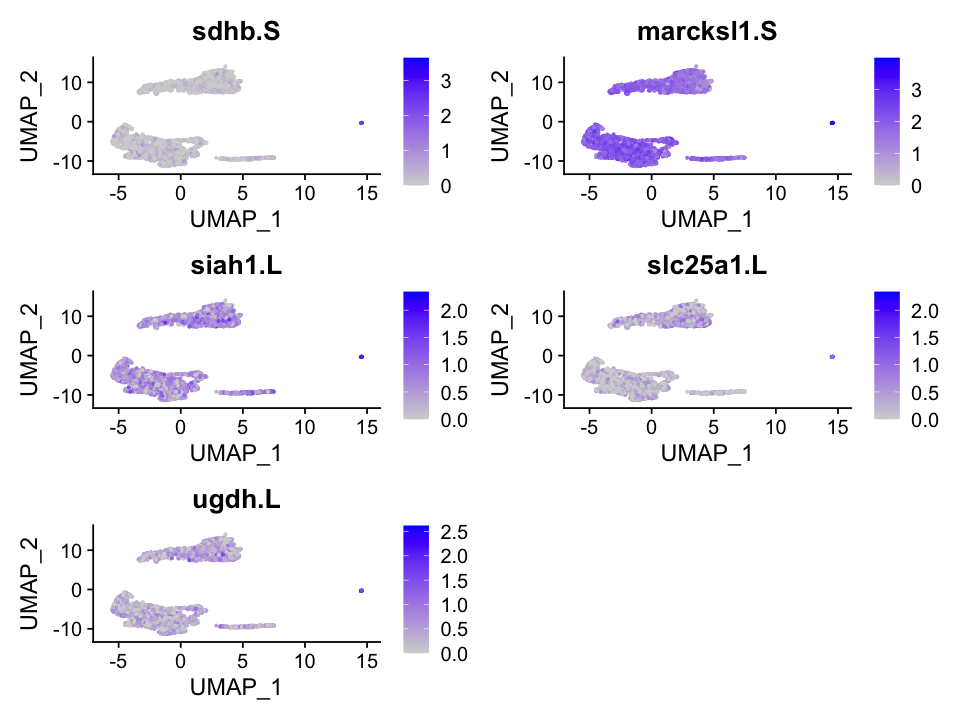

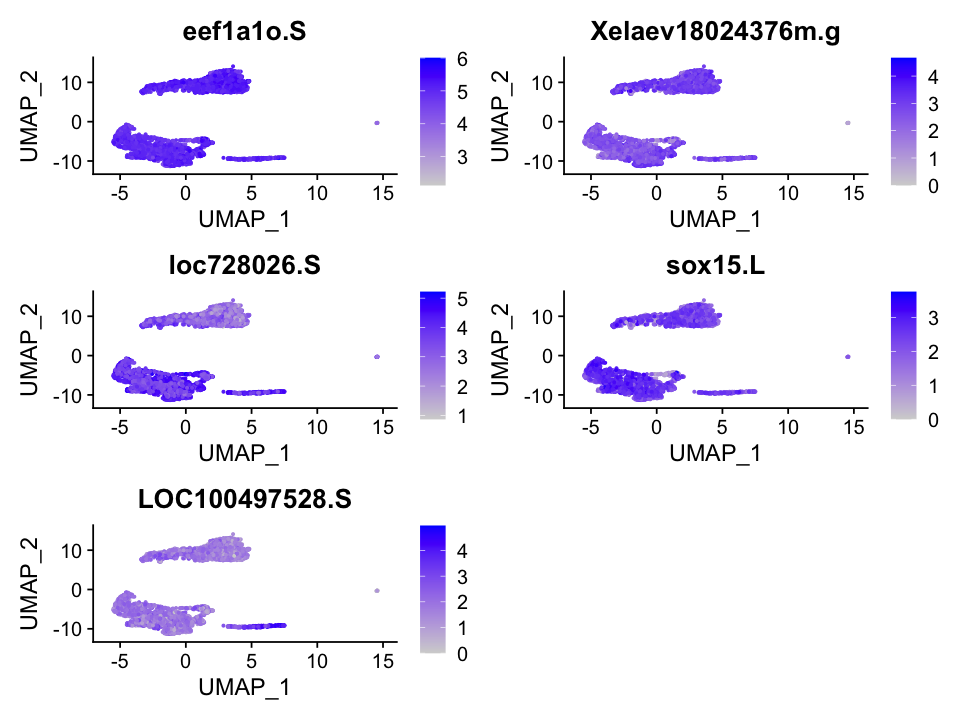

In [19]:
# Plot top 5 genes up and top 5 genes down in outliers
FeaturePlot(xenopus.combined, features = rownames(res.up.outliers)[1:5])
FeaturePlot(xenopus.combined, features = rownames(res.down.outliers)[1:5])

In [43]:
library(openxlsx)
wb <- createWorkbook()
addWorksheet(wb, "Genes_up_outliers")
addWorksheet(wb, "Genes_down_outliers")
writeData(wb, 1, res.up.outliers[,c("log2FoldChange","padj")],rowNames = TRUE)
writeData(wb, 2, res.down.outliers[,c("log2FoldChange","padj")],rowNames = TRUE)
saveWorkbook(wb, file = "DE_outliers_cluster6.xlsx", overwrite = TRUE)

# Mapping genes to GO terms and human orthologs

We load the mapping between gene names and GO terms (it can be found at [Xenbase](http://ftp.xenbase.org/pub/GenePageReports/)).

We also try with human orthologs and see which of the two options retains more genes.

In [22]:
# Convert symbols to IDs
folder <- "/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Conversion_ID_names/"

conversion.id.names <- read.table(paste(folder,"conversion_geneID_genename_Xenopus_Laevis.csv",sep=""),
                                  header=TRUE,sep=",")

In [23]:
folder <- "/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Gene_lists/"

mapping.gene.GO <- read.table(paste(folder,"GeneGoTerms.txt",sep=""),sep="\t")
colnames(mapping.gene.GO)[2:4] <- c("Xenbase_gene_ID","gene_symbol","GO_Ids")

# # Retain only gene symbol and GO terms columns
# sub.mapping.gene.GO <- mapping.gene.GO[, c("gene_symbol","GO_Ids")]

# # Remove duplicated rows
# sub.mapping.gene.GO <- distinct(sub.mapping.gene.GO)

# # Keep the intersection with the genes in the mapping ID/names
# x<-intersect(sub.mapping.gene.GO$gene_symbol,conversion.id.names$gene_name)

# # Subset the mapping with GO terms considering only gene names that we have in the ID/names conversion
# sub.mapping.gene.GO <- subset(sub.mapping.gene.GO, gene_symbol %in% x)

# # Set the gene symbols as index
# rownames(sub.mapping.gene.GO) <- sub.mapping.gene.GO$gene_symbol

In [24]:
# Note: there are more gene IDs mapping to the same gene name
# sub.conversion.id.names <- subset(conversion.id.names, gene_name %in% rownames(sub.mapping.gene.GO))

# sub.conversion.id.names <- sub.conversion.id.names[,c("gene_id","gene_name")]
# rownames(sub.conversion.id.names) <- sub.conversion.id.names$gene_name

In [25]:
bg <- rownames(res)

In [26]:
# Check the intersection between the background list of genes used for DE analysis
# and the gene_symbol column in the mapping list
print(c(length(bg),length(mapping.gene.GO$gene_symbol),
               length(intersect(bg,mapping.gene.GO$gene_symbol))))

print(c(length(rownames(res.up.outliers)),length(mapping.gene.GO$gene_symbol),
               length(intersect(rownames(res.up.outliers),mapping.gene.GO$gene_symbol))))

print(c(length(rownames(res.down.outliers)),length(mapping.gene.GO$gene_symbol),
               length(intersect(rownames(res.down.outliers),mapping.gene.GO$gene_symbol))))

[1]  7694 30888  5396
[1]   373 30888   264
[1]   216 30888   155


In [27]:
mapping.human <- read.table(paste(folder,"GeneGenomeHumanOrtho_xl9_1.txt",sep=""),sep="\t")
colnames(mapping.human) <- c("XENBASE_GENE_ID","SYMBOL","XENBASE_GENEPAGE_ID",
                             "XENBASE_TRANSCRIPT_ID","ENTREZ_GENE_ID","MODEL_NAME","NCBI_GENE_ID",
                             "DB_ID","GENOME_ASSEMBLY","ENSEMBL","HGNC_ID","ORTHOLOG_HUMAN_SYMBOL",
                             "ORTHOLOG_HUMAN_ENTREZ")

In [28]:
require(dplyr)

HumanOrtho <-function(glist,conv.list,human.map){
    tmp.df <- subset(conv.list, gene_name %in% glist)
    ids.glist <- tmp.df$gene_id
    tmp.df.2 <- subset(human.map, MODEL_NAME %in% ids.glist)
    x<-tmp.df.2$ORTHOLOG_HUMAN_SYMBOL
    x<- x[x != ""]
    unique(x)
    }

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:matrixStats’:

    count


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [29]:
human.bg <- HumanOrtho(bg,conversion.id.names,mapping.human)
human.res.up.out <- HumanOrtho(rownames(res.up.outliers),conversion.id.names,mapping.human)
human.res.down.out <- HumanOrtho(rownames(res.down.outliers),conversion.id.names,mapping.human)

In [30]:
# Check the intersection between the background list of genes used for DE analysis
# and the gene_symbol column in the mapping list
print(c(length(bg),length(human.bg)))

print(c(length(rownames(res.up.outliers)),length(human.res.up.out)))

print(c(length(rownames(res.down.outliers)),length(human.res.down.out)))

[1] 7694 4774
[1] 373 275
[1] 216 144


In [31]:
# # Less than half of our gene names are present in the gene -> GO mapping
# genes.not.mapped <- setdiff(bg,
#                             intersect(bg,mapping.gene.GO$gene_symbol))

# topGO for the DE genes

Note on topGO: It allows only selection of 'interesting' (e.g., differentially expressed) genes based on p-values (or adjusted p-values in our case) and not on log fold changes.

For this reason we will select as the 'gene universe' the tested genes returned by DESeq2 with logFC > 0 (<0) to perform the GO analysis for genes upregulated (downregulated) in the outliers of cluster 6.

The selection function for the interesting genes will be just a filter on the adjusted p-values (<0.05).

We will format the genes -> GO terms mapping downloaded from Xenbase according to the requirements of topGO.

In [32]:
require(topGO)

Loading required package: topGO

Loading required package: graph

Loading required package: GO.db

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:dplyr’:

    select




Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve



groupGOTerms: 	GOBPTerm, GOMFTerm, GOCCTerm environments built.


Attaching package: ‘topGO’


The following object is masked from ‘package:IRanges’:

    members




In [33]:
# Select only the gene name and GO terms columns in the mapping genes -> GO terms
my.map.gene.GO <- mapping.gene.GO[,c("gene_symbol","GO_Ids")]

# Format it as a named character vector
gene2GO.Xen <- as.character(my.map.gene.GO$GO_Ids)
names(gene2GO.Xen) <- my.map.gene.GO$gene_symbol

In [34]:
selFun <- function(gList){
    gList<0.05
}

topGO.XeLaev <- function(geneList,gene2GO.Xen,description.string){
    GOdata <- new("topGOdata",
               description = description.string,
               ontology = "BP",
               allGenes = geneList,
               geneSel = selFun,
               annot = annFUN.gene2GO,
               nodeSize = 5,
               gene2GO = gene2GO.Xen)
    resultFisher <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
    resultKS <- runTest(GOdata, algorithm = "classic", statistic = "ks")
    resultKS.elim <- runTest(GOdata, algorithm = "elim", statistic = "ks")
    allRes <- GenTable(GOdata, classicFisher = resultFisher,
                    classicKS = resultKS, elimKS = resultKS.elim,
                    orderBy = "elimKS", ranksOf = "classicFisher", topNodes = 5)
}




In [35]:
# Define the full list of genes with logFC>0
geneList.up <- res[res$log2FoldChange>0,]$padj
names(geneList.up) <- rownames(res[res$log2FoldChange>0,])
length(geneList.up)
sum(selFun(geneList.up))

# Define the full list of genes with logFC<0
geneList.down <- res[res$log2FoldChange<0,]$padj
names(geneList.down) <- rownames(res[res$log2FoldChange<0,])
length(geneList.down)
sum(selFun(geneList.down))

[1] 4496

[1] 373

[1] 3198

[1] 216

In [36]:
GO.up.genes <- topGO.XeLaev(geneList.up,gene2GO.Xen,
                            "GO of genes upregulated in outlier cells of cluster 6")
GO.down.genes <- topGO.XeLaev(geneList.down,gene2GO.Xen,
                            "GO of genes downregulated in outlier cells of cluster 6")


Building most specific GOs .....

	( 41 GO terms found. )


Build GO DAG topology ..........

	( 317 GO terms and 634 relations. )


Annotating nodes ...............

	( 58 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 30 nontrivial nodes
		 parameters: 
			 test statistic: fisher


			 -- Classic Algorithm -- 

		 the algorithm is scoring 63 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 63 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing


	 Level 11:	1 nodes to be scored	(0 eliminated genes)


	 Level 10:	2 nodes to be scored	(0 eliminated genes)


	 Level 9:	2 nodes to be scored	(0 eliminated genes)


	 Level 8:	3 nodes to be scored	(0 eliminated genes)


	 Level 7:	2 nodes to be scored	(0 eliminated genes)


	 Level 6:	9 nodes to be scored	(0 eliminated genes)


	 Level 5:	16 nodes to be 

In [37]:
GO.up.genes

,GO.ID,Term,Annotated,Significant,Expected,Rank in classicFisher,classicFisher,classicKS,elimKS
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>
1,GO:1901564,organonitrogen compound metabolic proces...,6,0,0.52,30,1.00,0.068,0.068
2,GO:0019538,protein metabolic process,5,0,0.43,31,1.00,0.111,0.111
3,GO:0044267,cellular protein metabolic process,5,0,0.43,32,1.00,0.111,0.111
4,GO:0009987,cellular process,47,5,4.05,6,0.33,0.251,0.251
5,GO:0048523,negative regulation of cellular process,7,0,0.60,33,1.00,0.298,0.298


In [38]:
GO.down.genes

,GO.ID,Term,Annotated,Significant,Expected,Rank in classicFisher,classicFisher,classicKS,elimKS
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>
1,GO:0016043,cellular component organization,7,0,0.29,5,1,0.050,0.050
2,GO:0006996,organelle organization,5,0,0.20,6,1,0.098,0.098
3,GO:0071840,cellular component organization or bioge...,10,0,0.41,7,1,0.190,0.190
4,GO:0006396,RNA processing,9,0,0.37,8,1,0.266,0.266
5,GO:0032501,multicellular organismal process,6,0,0.24,9,1,0.294,0.294


# Remove outliers and save raw and integrated data

In [18]:
xenopus.combined <- readRDS(file = "xenopus_combined_and_clustered.rds")
xenopus.combined.raw <- readRDS(file = "xenopus_combined_and_clustered_raw.rds")

new.cell.names <- setdiff(colnames(xenopus.combined),out_cell_names)

xenopus.combined.new <- subset(xenopus.combined, cells=new.cell.names)
xenopus.combined.raw.new <- subset(xenopus.combined.raw, cells=new.cell.names)

saveRDS(xenopus.combined.new, file = "xenopus_combined_and_clustered_no_out.rds")
saveRDS(xenopus.combined.raw.new, file = "xenopus_combined_and_clustered_raw_no_out.rds")

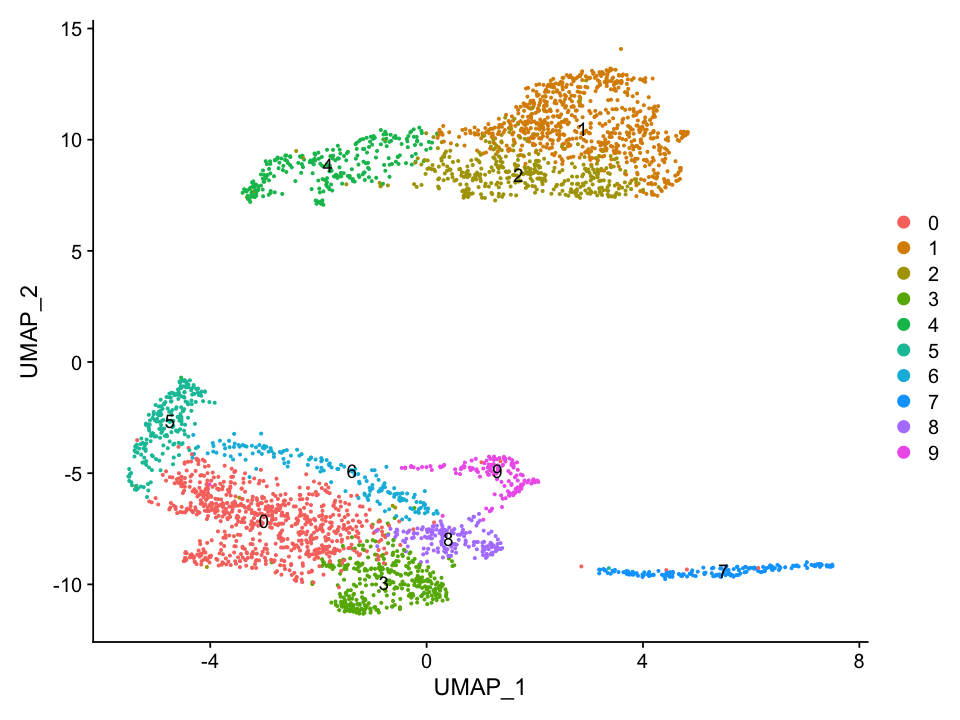

In [20]:
DimPlot(xenopus.combined.new, reduction = "umap",cols=my_color_palette, label = TRUE)

In [41]:
sessionInfo()

R version 3.5.2 (2018-12-20)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Mojave 10.14.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] topGO_2.34.0                SparseM_1.78               
 [3] GO.db_3.7.0                 AnnotationDbi_1.44.0       
 [5] graph_1.60.0                dplyr_1.0.2                
 [7] scran_1.10.2                SingleCellExperiment_1.4.1 
 [9] DESeq2_1.22.2               SummarizedExperiment_1.12.0
[11] DelayedArray_0.8.0          BiocParallel_1.16.6        
[13] matrixStats_0.57.0          Biobase_2.42.0             
[15] GenomicRanges_1.34.0        GenomeInfoDb_1.18.2        
[17] IRanges_2.16.0             